<a href="https://colab.research.google.com/github/diegorusso/deep-learning-from-scratch/blob/master/04_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overfitting and Regularization

Let's generate a new dataset: a straight line added to a sine wave and some random noise (unwanted of course)


In [1]:
import numpy as np

def generate_datasets(n_points):
    
    global train_x, train_y, test_x, test_y

    def generate_dataset(seed, n_points):
        train_slope  = 0.1
        train_offset = -1.0
        x = np.linspace(-10, 10, n_points).astype(np.float32)
        rng = np.random.RandomState(seed=seed)
        y = (train_slope * x + np.sin(x / 1.5) + train_offset +
                   rng.normal(0.0, 0.2, size=len(x))).astype(np.float32)
        return (x,y)

    # Training dataset
    train_x, train_y = generate_dataset(42, n_points)

    # Test dataset
    test_x, test_y = generate_dataset(43, n_points)

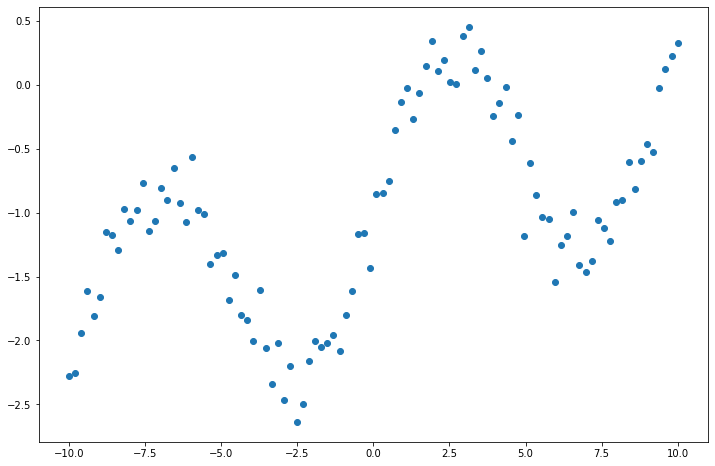

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

generate_datasets(n_points=100)

plt.rcParams["figure.figsize"] = (12, 8)
plt.plot(train_x, train_y, 'o');
plt.show()

Let's do some reshape of the training and test data and normalise the data into the range [-1.0, 1.0].

In [3]:
train_x = train_x.reshape(-1, 1)
train_y = train_y.reshape(-1, 1)
train_x = train_x - np.mean(train_x, axis=0)
train_x = train_x / np.max(train_x, axis=0)

test_x = test_x.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)
test_x = test_x - np.mean(test_x, axis=0)
test_x = test_x / np.max(test_x, axis=0)

Now we are going to play around with **hyperparameters** of the network, like number of layers and number of the units.
We will do this in iterative way:
* train the network
* measure the cost and the accuracy
* change the value of some hyperparameter
* repeat the experiment
* compare the results

This because there is a danger that our choice of hyperparameters will be biased by the specific data samples that forms the training dataset.

The outcome would be that our network gives excellent results with the training datasets but poorer results when presented new data sample it has never seen before.

To avoid this situation we hold back a subset of the training data sample to form a **test dataset** (or **validation dataset**). Once the model is trained with the train dataset we can measure loss and accuracy with the validation dataset. The ratio between training and validation dataset is **3:1 or 4:1**

Another important measure is to **shuffle** data so they can be presented to the network in random order during training.

Let's report in code what we have just said.

In [8]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_and_run_regression_graph(num_layers, num_hidden, num_steps, num_runs):
    
    # Number of data points
    m = train_x.shape[0]

    training_loss_for_run = []
    test_loss_for_run = []
    prediction_for_run = []

    for run in range(num_runs):
        tensorflow.keras.backend.clear_session()
        
        model = Sequential()

        # First hidden layer
        model.add(Dense(input_shape=(1,), units=num_hidden, activation='relu'))

        # Subsequent hidden layers
        for i in range(1,num_layers):
            model.add(Dense(units=num_hidden, activation='relu'))

        # Output layer
        model.add(Dense(units=1))
        
        if (run == 0): model.summary()

        model.compile(loss='mean_squared_error', optimizer='adam')

        #stopping = tensorflow.keras.callbacks.EarlyStopping(
        #    monitor='loss', min_delta=0.00001, patience=50, verbose=1)

        model.fit(train_x, train_y, epochs=num_steps, batch_size=m, verbose=0)#, callbacks=[stopping])

        training_loss = model.evaluate(train_x, train_y, batch_size=m, verbose=0)
        test_loss     = model.evaluate(test_x, test_y, batch_size=m, verbose=0)
        prediction    = model.predict(test_x, batch_size=m)
        
        print('Training loss = {:5.3f}, test loss = {:5.3f}'.format(
            training_loss, test_loss))

        training_loss_for_run.append(training_loss)
        test_loss_for_run.append(test_loss)
        prediction_for_run.append(prediction)

    print('Training loss min/mean/max = {:5.3f}/{:5.3f}/{:5.3f}'.format(
        np.min(training_loss_for_run), np.mean(training_loss_for_run), np.max(training_loss_for_run)))

    print('Test     loss min/mean/max = {:5.3f}/{:5.3f}/{:5.3f}'.format(
        np.min(test_loss_for_run), np.mean(test_loss_for_run), np.max(test_loss_for_run)))

    # Plot the runs as a sanity check
    plt.rcParams["figure.figsize"] = (12, 8)
    plt.plot(train_x, train_y, 'o');
    for run in range(num_runs):
        plt.plot(test_x, prediction_for_run[run])
    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________
Training loss = 0.149, test loss = 0.161
Training loss = 0.439, test loss = 0.408
Training loss = 0.156, test loss = 0.159
Training loss = 0.151, test loss = 0.163
Training loss = 0.215, test loss = 0.246
Training loss = 0.044, test loss = 0.072
Training loss = 0.044, test loss = 0.072
Training loss = 0.041, test loss = 0.050
Training loss = 0.438, test loss = 0.416
Training loss = 0.358, test loss = 0.330
Training loss min/mean/max = 0.041/0.204/0.439
Test     loss min/mean/max = 0.050/0.208/0.416


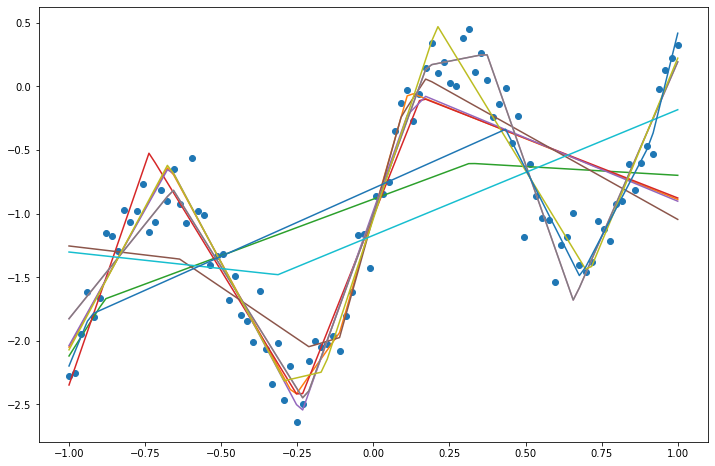

In [9]:
build_and_run_regression_graph(num_layers=1, num_hidden=6, num_steps=30000, num_runs=10)

We have run the above model with 6 units and one hidden layer. The model fits the data well in some runs but very badly on other runs. The gradient descend struggle to find a good minimum for the cost function in those cases.

The output shows also the minimum, mean and maximum loss for training and test. The thing to note the **big variation** in the cost across runs.

The runs that converge **most quickly**, meaning that the cost stops improving quickly, are also the runs with the **highest cost**, implying that the network has fallen into a **local minimum during training**.

To improve the situation we should increase the number of units and hidden layers.

Let's try with 1 hidden layer and 16 units



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________
Training loss = 0.029, test loss = 0.050
Training loss = 0.029, test loss = 0.050
Training loss = 0.029, test loss = 0.050
Training loss = 0.358, test loss = 0.329
Training loss = 0.029, test loss = 0.049
Training loss = 0.033, test loss = 0.054
Training loss = 0.033, test loss = 0.054
Training loss = 0.029, test loss = 0.049
Training loss = 0.028, test loss = 0.051
Training loss = 0.041, test loss = 0.072
Training loss min/mean/max = 0.028/0.064/0.358
Test     loss min/mean/max = 0.049/0.081/0.329


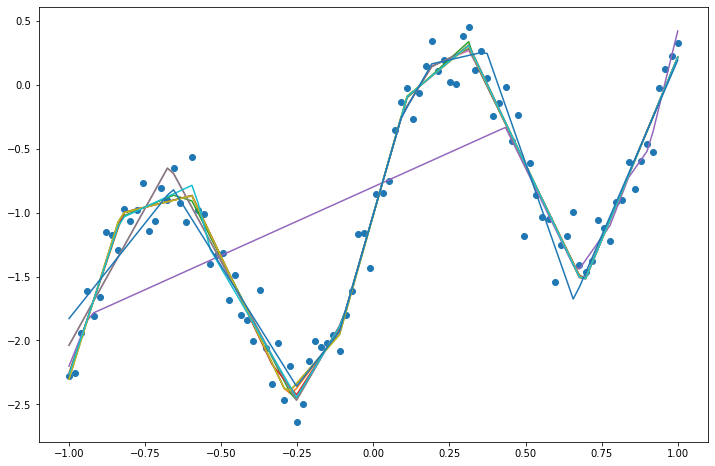

In [10]:
build_and_run_regression_graph(num_layers=1, num_hidden=16, num_steps=30000, num_runs=10)

Still there are runs where the model doesn't fit the data very well but we can start noticinfg a stronger overfitting.

As last example we try 4 hidden layers of 16 neurons per layer

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________
Training loss = 0.010, test loss = 0.057
Training loss = 0.012, test loss = 0.058
Training loss = 0.016, test loss = 0.057
T

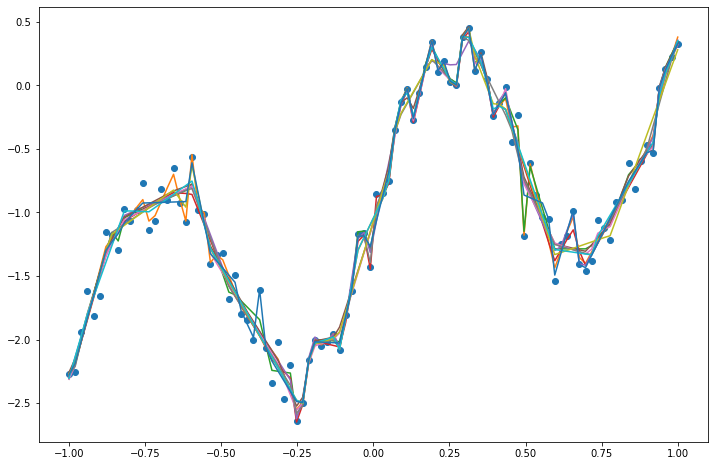

In [11]:
build_and_run_regression_graph(num_layers=4, num_hidden=16, num_steps=30000, num_runs=10)

Ok, in this last example the model adapted very well to the training data. It has even adapted to the noise we introduced! This is not a good thing because we can see a **strong overfit** to the trining data.

In fact the loss on the test data is much higher, hence the model won't do a great job when presenting new data.

We have decreased the variance across runs for test and training data but the difference between the 2 is high. This means we have an **overfit to the training data.**

The next steps are to make our network **bigger and deeper** and then take measure to avoid overfitting. Haw can we do it? **Adding more data** might not be a solution because the network can adapt to the new data.

The solution is to have some sort of **regularization mechanism.**

## Early termination

With this technique we **cut short the training as soon as the cost has stabilized at a reasonable level.**

## L2 regularization

L2 regularization works by adding an extra term to the cost function. If the cost is MSE we add this term to it to make the overall function **more unique**.

The term we add is the square of L2 norm (Euclidean norm) or weight vector.

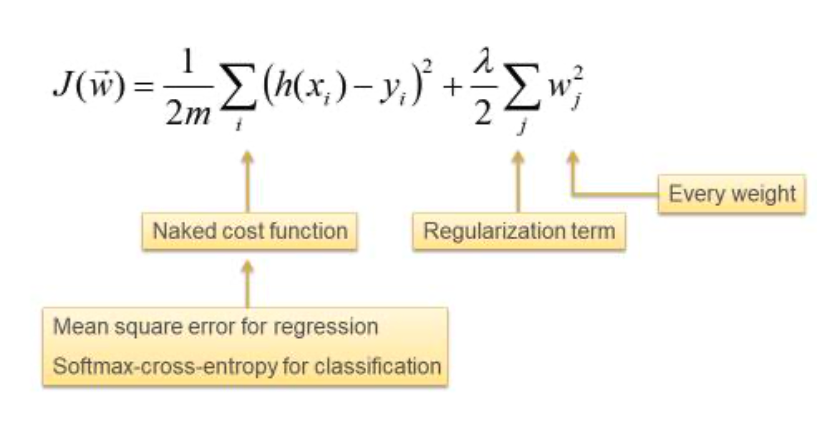

If you think of the weight vector as representing a single point in a high-dimensional space, the L2 norm represents the distance of that point from the origin



The L2 term includes a multiplicate constant lambda. If 0, we disable the term hence no regularization.
If lmbda is too large the network will not learn anything from the training data.

The optimal value of lambda has to be determined by experimentation. This parameters is one of the hyperparameters we need to set during training.

Values to try are: 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001

Let's try these 2 optimizations together.


In [4]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

def build_and_run_regression_graph_with_l2(num_layers, num_hidden, num_steps, num_runs, lambda_=0):
    
    # Number of data points
    m = train_x.shape[0]

    training_loss_for_run = []
    test_loss_for_run = []
    prediction_for_run = []
    

    for run in range(num_runs):
        tensorflow.keras.backend.clear_session()
        
        model = Sequential()

        # First hidden layer
        model.add(Dense(input_shape=(1,), units=num_hidden, activation='relu', kernel_regularizer=l2(lambda_)))

        # Subsequent hidden layers
        for i in range(1,num_layers):
            # We add our L2 regularizer
            model.add(Dense(units=num_hidden, activation='relu', kernel_regularizer=l2(lambda_)))

        # Output layer
        model.add(Dense(units=1))
        
        if (run == 0): model.summary()

        model.compile(loss='mean_squared_error', optimizer='adam')

        # We define the Early Termination
        stopping = tensorflow.keras.callbacks.EarlyStopping(
            monitor='loss', min_delta=0.00001, patience=50, verbose=1)

        model.fit(train_x, train_y, epochs=num_steps, batch_size=m, verbose=0, callbacks=[stopping])

        training_loss = model.evaluate(train_x, train_y, batch_size=m, verbose=0)
        test_loss     = model.evaluate(test_x, test_y, batch_size=m, verbose=0)
        prediction    = model.predict(test_x, batch_size=m)
        
        print('Training loss = {:5.3f}, test loss = {:5.3f}'.format(
            training_loss, test_loss))

        training_loss_for_run.append(training_loss)
        test_loss_for_run.append(test_loss)
        prediction_for_run.append(prediction)

    print('Training loss min/mean/max = {:5.3f}/{:5.3f}/{:5.3f}'.format(
        np.min(training_loss_for_run), np.mean(training_loss_for_run), np.max(training_loss_for_run)))

    print('Test     loss min/mean/max = {:5.3f}/{:5.3f}/{:5.3f}'.format(
        np.min(test_loss_for_run), np.mean(test_loss_for_run), np.max(test_loss_for_run)))

    # Plot the runs as a sanity check
    plt.rcParams["figure.figsize"] = (12, 8)
    plt.plot(train_x, train_y, 'o');
    for run in range(num_runs):
        plt.plot(test_x, prediction_for_run[run])
    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________
Training loss = 0.123, test loss = 0.140
Epoch 16554: early stopping
Training loss = 0.158, test loss = 0.177
Epoch 25994: e

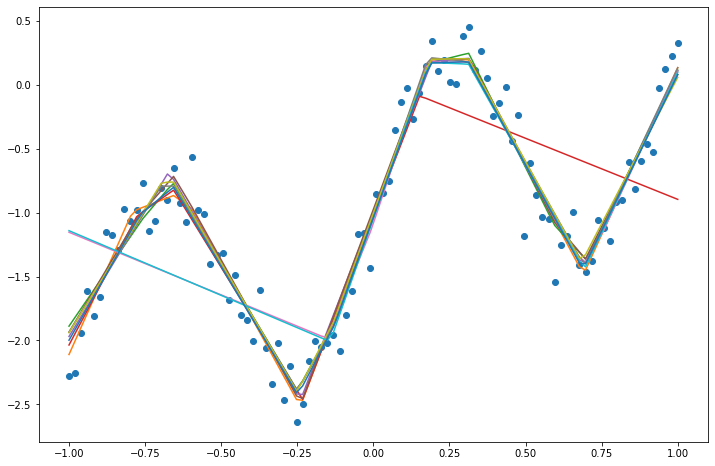

In [7]:
build_and_run_regression_graph_with_l2(num_layers=4, num_hidden=16, num_steps=30000, num_runs=10, lambda_=0.03)